In [142]:
import collections
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier, MaxentClassifier, SklearnClassifier
import csv
from sklearn import cross_validation
from sklearn.svm import LinearSVC, SVC
import random
from nltk.corpus import stopwords
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import *
import matplotlib.pyplot as plt

In [143]:
from __future__ import division #To avoid integer division
from operator import itemgetter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [144]:
data = pd.read_csv("data_set.csv", low_memory=False)
data = data[['reviews.rating', 'reviews.text']]
train, test = train_test_split(data, test_size=0.2)

In [145]:
pos_rev = []
# pos_rev_date = []
neg_rev = []
# neg_rev_date = []
neut_rev = []
# neut_rev_date = []

train['reviews.rating'] = pd.to_numeric(train['reviews.rating'], errors='coerce')
train = train.dropna(subset=['reviews.rating'])
train['reviews.rating'] = train['reviews.rating'].astype(int)

# a = 0
for col, row in train.iterrows():
    if int(row["reviews.rating"]) > 3:
        pos_rev.append(row["reviews.text"])
#         pos_rev_date.append(row["reviews.date"])
    elif int(row["reviews.rating"]) < 3:
        neg_rev.append(row["reviews.text"])
#         neg_rev_date.append(row["reviews.date"])
    else:
        neut_rev.append(row["reviews.text"])
#         neut_rev_date.append(row["reviews.date"])

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [146]:
def word_split(data):    
    data_new = []
    for word in data:
        try:
            word_filter = [i.lower() for i in word.split()]
            data_new.append(word_filter)
        except:
            print (' ')
    return data_new
 
def word_split_sentiment(data):
    data_new = []
    for (word, sentiment) in data:
        try:
            word_filter = [i.lower() for i in word.split()]
            data_new.append((word_filter, sentiment))
        except:
            print (' ')
    return data_new
    
def word_feats(words):    
    return dict([(word, True) for word in words])

In [147]:
from nltk.metrics import *

single_accuracy = 0
single_precision = 0
single_recall = 0
single_fmeasure = 0

ncross_accuracy = 0
ncross_precision = 0
ncross_recall = 0
ncross_fmeasure = 0

s_a = []
s_p = []
s_r = []
s_fm = []
n_a = []
n_p = []
n_r = []
n_fm = []
# ncross_metrics = []

def evaluate_classifier(featx):
    
    negfeats = [(featx(f), 'neg') for f in word_split(neg_rev)]
    posfeats = [(featx(f), 'pos') for f in word_split(pos_rev)]
    neutfeats = [(featx(f), 'neut') for f in word_split(neut_rev)]
    
#     print (posfeats)
        
    negcutoff = int(len(negfeats)*3/4)
    poscutoff = int(len(posfeats)*3/4)
    neutcutoff = int(len(neutfeats)*3/4)
    
#     print (len(posfeats))
#     print (len(negfeats))
#     print (len(neutfeats))
    
    trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff] + neutfeats[:neutcutoff]
    testfeats = negfeats[negcutoff:] + posfeats[poscutoff:] + neutfeats[neutcutoff:]
    
    # using 3 classifiers
    classifier_list = ['nb', 'maxent', 'svm']
        
    for cl in classifier_list:
        if cl == 'maxent':
            classifierName = 'Maximum Entropy'
            classifier = MaxentClassifier.train(trainfeats, 'GIS', trace=0, encoding=None, labels=None, gaussian_prior_sigma=0, max_iter = 1)
        elif cl == 'svm':
            classifierName = 'SVM'
            classifier = SklearnClassifier(LinearSVC(), sparse=False)
            classifier.train(trainfeats)
        else:
            classifierName = 'Naive Bayes'
            classifier = NaiveBayesClassifier.train(trainfeats)
            
        refsets = collections.defaultdict(set)
        testsets = collections.defaultdict(set)
 
        for i, (feats, label) in enumerate(testfeats):
                refsets[label].add(i)
                observed = classifier.classify(feats)
                testsets[observed].add(i)

        accuracy = nltk.classify.util.accuracy(classifier, testfeats)
        pos_precision = precision(refsets['pos'], testsets['pos'])
        pos_recall = recall(refsets['pos'], testsets['pos'])
        pos_fmeasure = f_measure(refsets['pos'], testsets['pos'])
        neg_precision = precision(refsets['neg'], testsets['neg'])
        neg_recall = recall(refsets['neg'], testsets['neg'])
        neg_fmeasure = f_measure(refsets['neg'], testsets['neg'])
        neut_precision = precision(refsets['neut'], testsets['neut'])
        neut_recall = recall(refsets['neut'], testsets['neut'])
        neut_fmeasure = f_measure(refsets['neut'], testsets['neut'])
        
        if pos_precision is None:
            pos_precision = 0
        if pos_recall is None:
            pos_recall = 0
        if pos_fmeasure is None:
            pos_fmeasure = 0
        if neg_precision is None:
            neg_precision = 0
        if neg_recall is None:
            neg_recall = 0
        if neg_fmeasure is None:
            neg_fmeasure = 0
        if neut_precision is None:
            neut_precision = 0
        if neut_recall is None:
            neut_recall = 0
        if neut_fmeasure is None:
            neut_fmeasure = 0
        
        single_accuracy = accuracy
        single_precision = (pos_precision + neg_precision + neut_precision) / 3
        single_recall = (pos_recall + neg_recall + neut_recall) / 3
        single_fmeasure = (pos_fmeasure + neg_fmeasure + neut_fmeasure) / 3
        
        s_a.append(single_accuracy * 100)
        s_p.append(single_precision * 100)
        s_r.append(single_recall * 100)
        s_fm.append(single_fmeasure * 100)
        
        print (' ')
        print ('---------------------------------------')
        print ('SINGLE FOLD RESULT ' + '(' + classifierName + ')')
        print ('---------------------------------------')
        print ('accuracy:', accuracy * 100)
        print ('precision', single_precision * 100)
        print ('recall', single_recall * 100)
        print ('f-measure', single_fmeasure * 100)
                
        #classifier.show_most_informative_features()
        
    trainfeats = negfeats + posfeats + neutfeats
    
    # SHUFFLE TRAIN SET
    # As in cross validation, the test chunk might have only negative or only positive data    
    random.shuffle(trainfeats)    
    n = 5 # 5-fold cross-validation    
    
    for cl in classifier_list:
        
        subset_size = int(len(trainfeats) / n)
        accuracy = []
        pos_precision = []
        pos_recall = []
        neg_precision = []
        neg_recall = []
        pos_fmeasure = []
        neg_fmeasure = []
        neut_precision = []
        neut_recall = []
        neut_fmeasure = []
        cv_count = 1
        for i in range(n):        
            testing_this_round = trainfeats[i*subset_size:][:subset_size]
            training_this_round = trainfeats[:i*subset_size] + trainfeats[(i+1)*subset_size:]
            
            if cl == 'maxent':
                classifierName = 'Maximum Entropy'
                classifier = MaxentClassifier.train(training_this_round, 'GIS', trace=0, encoding=None, labels=None, gaussian_prior_sigma=0, max_iter = 1)
            elif cl == 'svm':
                classifierName = 'SVM'
                classifier = SklearnClassifier(LinearSVC(), sparse=False)
                classifier.train(training_this_round)
            else:
                classifierName = 'Naive Bayes'
                classifier = NaiveBayesClassifier.train(training_this_round)
                    
            refsets = collections.defaultdict(set)
            testsets = collections.defaultdict(set)
            for i, (feats, label) in enumerate(testing_this_round):
                refsets[label].add(i)
                observed = classifier.classify(feats)
                testsets[observed].add(i)
            
            cv_accuracy = 0
            cv_pos_precision = 0
            cv_pos_recall = 0
            cv_pos_fmeasure = 0
            cv_neg_precision = 0
            cv_neg_recall = 0
            cv_neg_fmeasure = 0
            cv_neut_precision = 0
            cv_neut_recall = 0
            cv_neut_fmeasure = 0
            
            cv_accuracy = nltk.classify.util.accuracy(classifier, testing_this_round)
            cv_pos_precision = precision(refsets['pos'], testsets['pos'])
            cv_pos_recall = recall(refsets['pos'], testsets['pos'])
            cv_pos_fmeasure = f_measure(refsets['pos'], testsets['pos'])
            cv_neg_precision = precision(refsets['neg'], testsets['neg'])
            cv_neg_recall = recall(refsets['neg'], testsets['neg'])
            cv_neg_fmeasure = f_measure(refsets['neg'], testsets['neg'])
            cv_neut_precision = precision(refsets['neut'], testsets['neut'])
            cv_neut_recall = recall(refsets['neut'], testsets['neut'])
            cv_neut_fmeasure = f_measure(refsets['neut'], testsets['neut'])
            
            if cv_pos_precision is None:
                cv_pos_precision = 0
            if cv_pos_recall is None:
                cv_pos_recall = 0
            if cv_pos_fmeasure is None:
                cv_pos_fmeasure = 0
            if cv_neg_precision is None:
                cv_neg_precision = 0
            if cv_neg_recall is None:
                cv_neg_recall = 0
            if cv_neg_fmeasure is None:
                cv_neg_fmeasure = 0
            if cv_neut_precision is None:
                cv_neut_precision = 0
            if cv_neut_recall is None:
                cv_neut_recall = 0
            if cv_neut_fmeasure is None:
                cv_neut_fmeasure = 0

                    
            accuracy.append(cv_accuracy)
            pos_precision.append(cv_pos_precision)
            pos_recall.append(cv_pos_recall)
            neg_precision.append(cv_neg_precision)
            neg_recall.append(cv_neg_recall)
            pos_fmeasure.append(cv_pos_fmeasure)
            neg_fmeasure.append(cv_neg_fmeasure)
            neut_precision.append(cv_neut_precision)
            neut_recall.append(cv_neut_recall)
            neut_fmeasure.append(cv_neut_fmeasure)
            
            cv_count += 1
            
            ncross_accuracy = sum(accuracy) / n
            ncross_precision = (sum(pos_precision)/n + sum(neg_precision)/n + sum(neut_precision)/n) / 3
            ncross_recall = (sum(pos_recall)/n + sum(neg_recall)/n + sum(neut_recall)/n) / 3
            ncross_fmeasure = (sum(pos_fmeasure)/n + sum(neg_fmeasure)/n + sum(neut_fmeasure)/n) / 3
            
            n_a.append(ncross_accuracy * 100)
            n_p.append(ncross_precision * 100)
            n_r.append(ncross_recall * 100)
            n_fm.append(ncross_fmeasure * 100)
        
                
        print ('---------------------------------------')
        print ('N-FOLD CROSS VALIDATION RESULT ' + '(' + classifierName + ')')
        print ('---------------------------------------')
        print ('accuracy:', ncross_accuracy * 100)
        print ('precision', ncross_precision * 100)
        print ('recall', ncross_recall * 100)
        print ('f-measure', ncross_fmeasure * 100)
        print ('')
        

In [148]:
evaluate_classifier(word_feats)

 
---------------------------------------
SINGLE FOLD RESULT (Naive Bayes)
---------------------------------------
accuracy: 0.4443321299638989
precision 0.3741185789800814
recall 0.5053032958724267
f-measure 0.2731002346759803
 
---------------------------------------
SINGLE FOLD RESULT (Maximum Entropy)
---------------------------------------
accuracy: 0.9337184115523466
precision 0.3112394705174489
recall 0.3333333333333333
f-measure 0.32190774898563707
 
---------------------------------------
SINGLE FOLD RESULT (SVM)
---------------------------------------
accuracy: 0.9223104693140795
precision 0.5664650583804192
recall 0.4622861463381105
f-measure 0.4950366481413125
---------------------------------------
N-FOLD CROSS VALIDATION RESULT (Naive Bayes)
---------------------------------------
accuracy: 0.46990431485827766
precision 0.37457017720443103
recall 0.5307276712175332
f-measure 0.28615530336611256

---------------------------------------
N-FOLD CROSS VALIDATION RESULT (Maxim

<Container object of 3 artists>

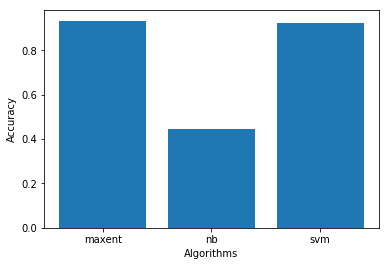

In [149]:
import numpy as np
# x = np.array(s_p)
# plt.hist(x, height = [s_p[0]], s_p[1], s_p[2])
# plt.xticks([1, 3, 5], ['nb', 'maxent', 'svm'])

x = ['nb', 'maxent', 'svm']
height = [s_a[0], s_a[1], s_a[2]]
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)

<Container object of 3 artists>

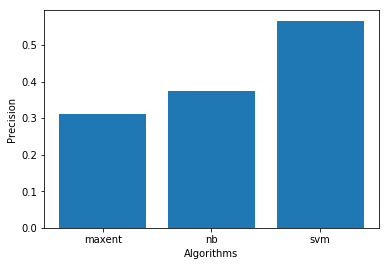

In [150]:
x = ['nb', 'maxent', 'svm']
height = [s_p[0], s_p[1], s_p[2]]
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)

<Container object of 3 artists>

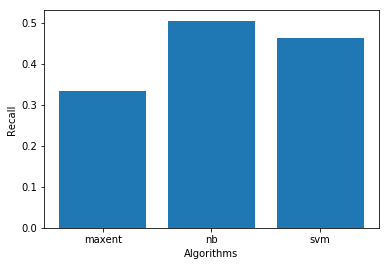

In [151]:
x = ['nb', 'maxent', 'svm']
height = [s_r[0], s_r[1], s_r[2]]
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)

<Container object of 3 artists>

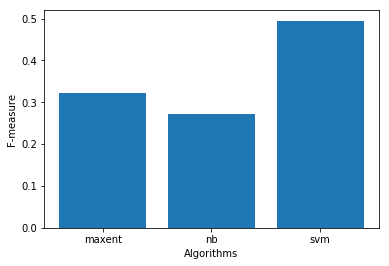

In [152]:
x = ['nb', 'maxent', 'svm']
height = [s_fm[0], s_fm[1], s_fm[2]]
plt.xlabel('Algorithms')
plt.ylabel('F-measure')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)

<Container object of 3 artists>

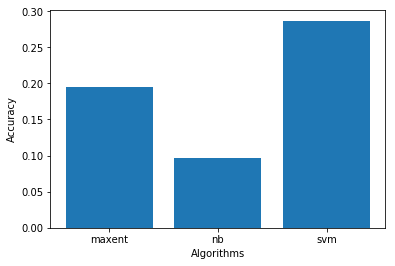

In [153]:
x = ['nb', 'maxent', 'svm']
height = [n_a[0], n_a[1], n_a[2]]
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)

<Container object of 3 artists>

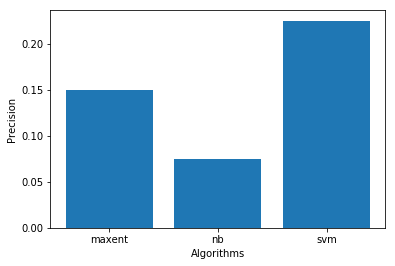

In [154]:
x = ['nb', 'maxent', 'svm']
height = [n_p[0], n_p[1], n_p[2]]
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)


<Container object of 3 artists>

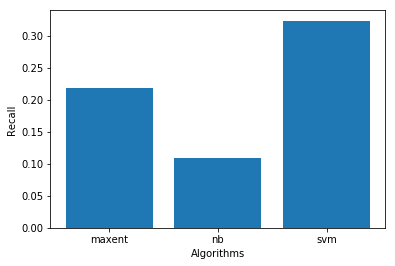

In [155]:
x = ['nb', 'maxent', 'svm']
height = [n_r[0], n_r[1], n_r[2]]
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)


<Container object of 3 artists>

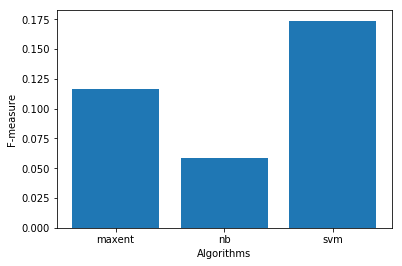

In [156]:
x = ['nb', 'maxent', 'svm']
height = [n_fm[0], n_fm[1], n_fm[2]]
plt.xlabel('Algorithms')
plt.ylabel('F-measure')
plt.bar(x, height, width = 0.8, bottom=None, align='center', data=None)